<a href="https://colab.research.google.com/github/JayV1I/Aulas-pucc/blob/main/perceptron_e_treeclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciando sessão Spark...
Sessão Spark iniciada com sucesso!

Carregando os dados...
Dataset carregado com sucesso!

Esquema do DataFrame:
root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullabl

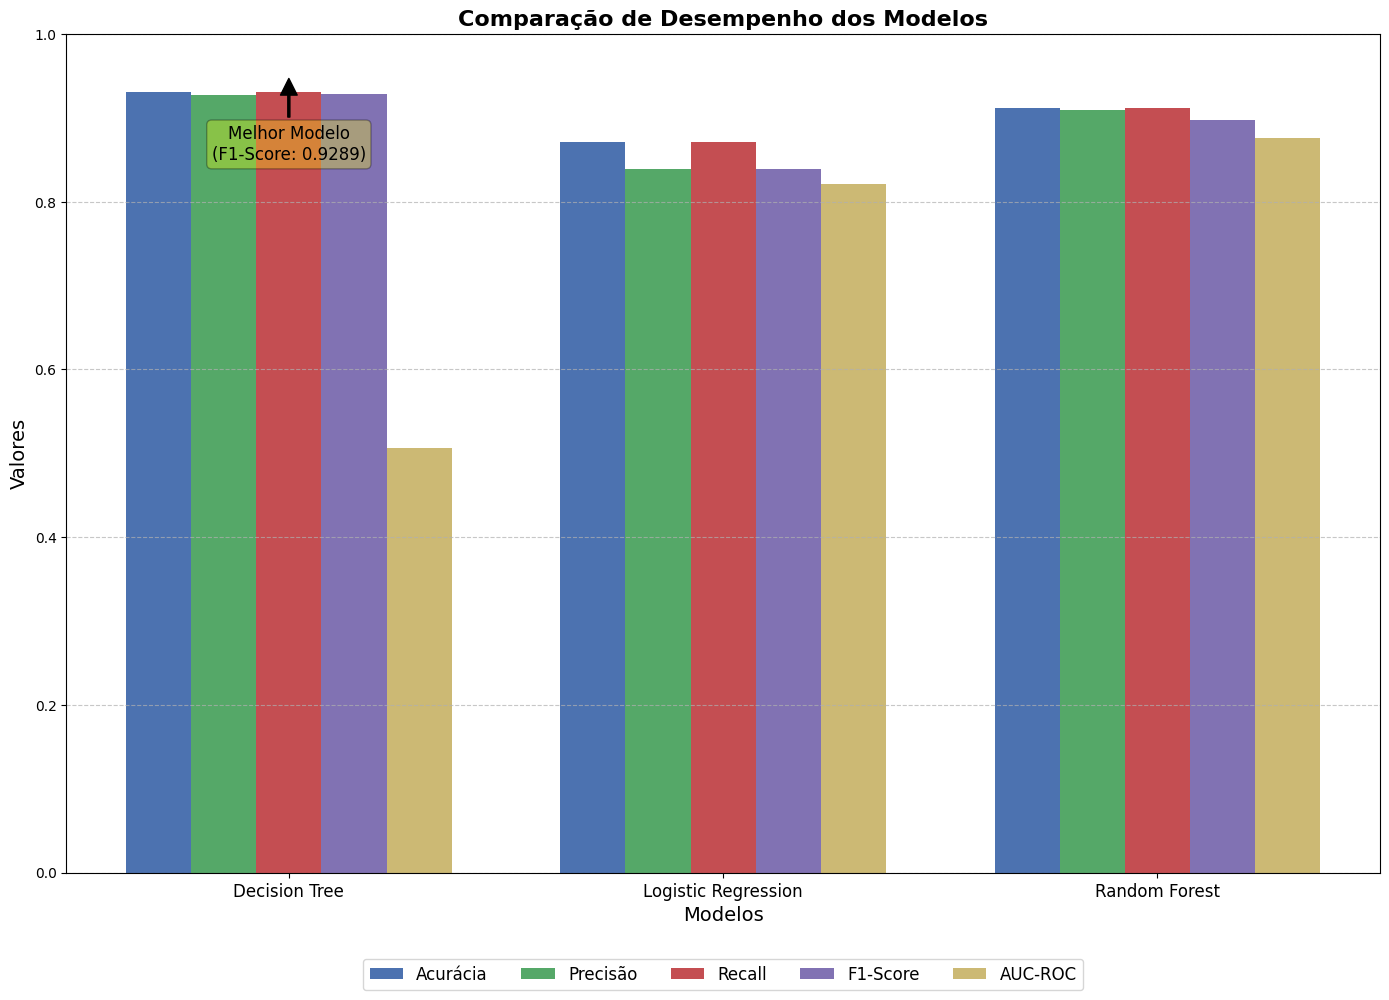


Criando dashboard das features mais importantes e matriz de confusão...


<ipython-input-11-4de2bb7a8131>:509: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Feature', data=features_df, ax=ax1, palette=color_palette)


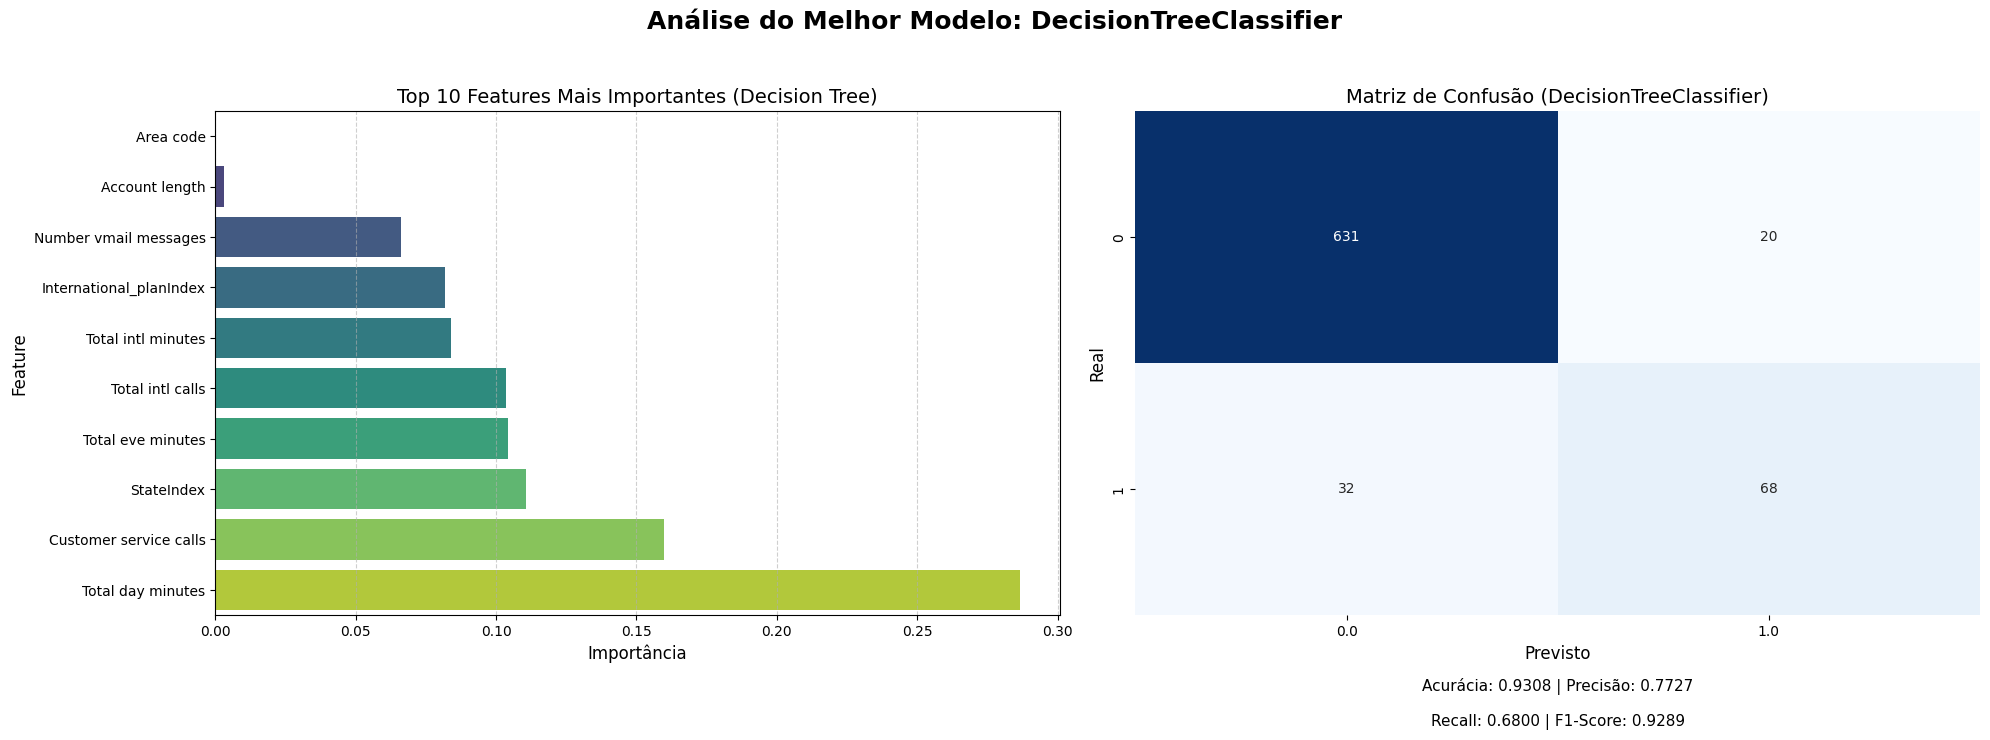


Finalizando processamento...

Sessão Spark encerrada com sucesso.


In [ ]:
# Projeto de Arquitetura de Grandes Volumes de Dados
# Previsão de Churn em Telecomunicações com Apache Spark

# Integrantes do Grupo:
# [João Vitor] - RA: [23007781]
# [Lucas Alain] - RA: [23009551]
# [Rafael Mateus] - RA: [23010763]
# [Raphael Bento] - RA: [ 23002292]

# Importação das bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, isnan, when, count, regexp_replace, trim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path

# 1. Criação da sessão Spark com tratamento de erro
try:
    print("Iniciando sessão Spark...")
    spark = SparkSession.builder.appName("TelecomChurnPrediction").getOrCreate()
    print("Sessão Spark iniciada com sucesso!\n")
except Exception as e:
    print(f"Erro ao iniciar sessão Spark: {e}")
    exit(1)

# 2. Carregamento e Exploração dos Dados
try:
    print("Carregando os dados...")
    # Verificação da existência do arquivo antes de carregar
    file_path = "/content/churn-bigml-80.csv"

    if not os.path.exists(file_path):
        print(f"ATENÇÃO: O arquivo {file_path} não foi encontrado!")
        print("Por favor, verifique o caminho do arquivo e tente novamente.")
        exit(1)

    df = spark.read.csv(file_path,
                        header=True,
                        inferSchema=True)

    print("Dataset carregado com sucesso!\n")

    # Verificação se o DataFrame foi carregado corretamente
    if df.count() == 0:
        print("ERRO: O DataFrame está vazio após o carregamento!")
        exit(1)

    # Visualização do esquema e primeiras linhas
    print("Esquema do DataFrame:")
    df.printSchema()

    print("\nPrimeiras 5 linhas do DataFrame:")
    df.show(5, truncate=False)

    # Contagem de registros e colunas
    print(f"\nTotal de registros: {df.count()}")
    print(f"Total de colunas: {len(df.columns)}")

    # Verificação se a coluna target existe
    if "Churn" not in df.columns:
        print("ERRO: A coluna 'Churn' não foi encontrada no DataFrame!")
        exit(1)

    # Verificando a distribuição da variável target (Churn)
    print("\nDistribuição da variável target (Churn):")
    df.groupBy("Churn").count().orderBy("count", ascending=False).show()

    # Verificando valores nulos por coluna - CORRIGIDO
    print("\nVerificando valores nulos por coluna:")
    null_counts = []
    for col_name in df.columns:
        # Verificando o tipo da coluna
        col_type = df.schema[col_name].dataType.simpleString()

        if "int" in col_type or "double" in col_type or "float" in col_type:
            # Para colunas numéricas, verificamos tanto null quanto NaN
            null_count = df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
        else:
            # Para colunas não numéricas, verificamos apenas null
            null_count = df.filter(col(col_name).isNull()).count()

        null_counts.append((col_name, null_count))

    null_columns = []
    for col_name, null_count in null_counts:
        if null_count > 0:
            print(f"Coluna '{col_name}' tem {null_count} valores nulos")
            null_columns.append(col_name)

    # Verificando registros duplicados
    duplicate_count = df.count() - df.dropDuplicates().count()
    print(f"\nTotal de registros duplicados: {duplicate_count}")

except Exception as e:
    print(f"Erro durante a exploração dos dados: {e}")
    exit(1)

# 3. Pré-processamento dos Dados
try:
    print("\n--- Pré-processamento dos Dados ---")

    # Limpeza de strings nas colunas categóricas
    string_columns = [f.name for f in df.schema.fields if f.dataType.simpleString() == "string"]
    for col_name in string_columns:
        df = df.withColumn(col_name, trim(regexp_replace(col(col_name), "\\s+", " ")))

    # Tratando valores nulos (se houver)
    if null_columns:
        print("\nTratando valores nulos...")
        for col_name in null_columns:
            # Verificando o tipo de dados da coluna
            col_type = df.schema[col_name].dataType.simpleString()

            if "int" in col_type or "double" in col_type or "float" in col_type:
                # Para colunas numéricas, substituímos nulos pela média
                mean_value = df.select(col_name).na.drop().agg({col_name: "avg"}).collect()[0][0]
                df = df.withColumn(col_name, when(col(col_name).isNull() | isnan(col(col_name)), mean_value).otherwise(col(col_name)))
            else:
                # Para colunas categóricas, substituímos por "Unknown"
                df = df.withColumn(col_name, when(col(col_name).isNull(), "Unknown").otherwise(col(col_name)))

    # Removendo registros duplicados (se houver)
    if duplicate_count > 0:
        print("\nRemovendo registros duplicados...")
        df = df.dropDuplicates()
        print(f"Registros após remoção de duplicatas: {df.count()}")

    # Criando a variável alvo (label) para classificação
    print("\nCriando variável target para classificação:")
    df = df.withColumn("label", (col("Churn") == "True").cast("integer"))

    # Verificando a distribuição da variável target
    print("\nDistribuição da variável target (label):")
    target_dist = df.groupBy("label").count().orderBy("label").collect()
    for row in target_dist:
        print(f"Classe {row['label']}: {row['count']} registros ({row['count']/df.count()*100:.2f}%)")

    # Identificando variáveis categóricas
    # Verificando automaticamente todas as colunas do tipo string que não são a variável target
    categorical_columns = [f.name for f in df.schema.fields if f.dataType.simpleString() == "string" and f.name != "Churn"]
    print(f"\nVariáveis categóricas identificadas: {categorical_columns}")

    # Indexando e codificando variáveis categóricas
    indexers = []
    indexed_cols = []
    for cat_col in categorical_columns:
        # Criando o indexer
        index_col = cat_col.replace(" ", "_") + "Index"
        indexers.append(StringIndexer(inputCol=cat_col, outputCol=index_col, handleInvalid="keep"))
        indexed_cols.append(index_col)

    # Aplicando os indexers
    for indexer in indexers:
        df = indexer.fit(df).transform(df)

    # Identificando variáveis numéricas (excluindo a coluna target e o ID)
    numeric_cols = [col_name for col_name in df.columns
                   if df.schema[col_name].dataType.simpleString() in ["int", "double", "float"]
                   and col_name not in ["label", "Churn", "customerID"]]

    print(f"\nVariáveis numéricas identificadas: {numeric_cols}")

    # Features para o modelo
    feature_cols = numeric_cols + indexed_cols
    print(f"\nTotal de features selecionadas: {len(feature_cols)}")
    print(f"Features: {feature_cols}")

    # Montando o vetor de features
    print("\nCriando vetor de features...")
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    data = assembler.transform(df).select("features", "label")

    # Verificando se há valores nulos no vetor de features
    null_features_count = data.filter(col("features").isNull()).count()
    print(f"Registros com valores nulos no vetor de features: {null_features_count}")

    if null_features_count > 0:
        print("Removendo registros com valores nulos no vetor de features...")
        data = data.na.drop(subset=["features"])

    # Dividindo os dados em conjuntos de treino e teste
    print("\nDividindo os dados em conjuntos de treino (70%) e teste (30%)...")
    train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)
    print(f"Conjunto de treino: {train_data.count()} registros")
    print(f"Conjunto de teste: {test_data.count()} registros")

except Exception as e:
    print(f"Erro durante o pré-processamento dos dados: {e}")
    exit(1)

# 4. Treinamento dos Modelos de Classificação
try:
    print("\n--- Treinamento dos Modelos de Classificação ---")

    # Modelo 1: DecisionTreeClassifier
    print("\nTreinando o modelo DecisionTreeClassifier...")
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, maxBins=100)
    model_dt = dt.fit(train_data)
    predictions_dt = model_dt.transform(test_data)

    # Modelo 2: LogisticRegression
    print("\nTreinando o modelo LogisticRegression...")
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
    model_lr = lr.fit(train_data)
    predictions_lr = model_lr.transform(test_data)

    # Modelo 3: RandomForestClassifier (adicionado)
    print("\nTreinando o modelo RandomForestClassifier...")
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxBins=100)
    model_rf = rf.fit(train_data)
    predictions_rf = model_rf.transform(test_data)

except Exception as e:
    print(f"Erro durante o treinamento dos modelos: {e}")
    exit(1)

# 5. Avaliação dos Modelos
try:
    print("\n--- Avaliação dos Modelos ---")

    # Função para calcular métricas de avaliação
    def calculate_metrics(predictions):
        # Métrica 1: AUC-ROC
        evaluator_auc = BinaryClassificationEvaluator(
            labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        auc = evaluator_auc.evaluate(predictions)

        # Métrica 2: Acurácia
        evaluator_acc = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator_acc.evaluate(predictions)

        # Métricas 3, 4 e 5: Precision, Recall e F1-Score
        evaluator_prec = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        precision = evaluator_prec.evaluate(predictions)

        evaluator_rec = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        recall = evaluator_rec.evaluate(predictions)

        evaluator_f1 = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="f1")
        f1 = evaluator_f1.evaluate(predictions)

        return accuracy, precision, recall, f1, auc

    # Calculando métricas para todos os modelos
    accuracy_dt, precision_dt, recall_dt, f1_dt, auc_dt = calculate_metrics(predictions_dt)
    accuracy_lr, precision_lr, recall_lr, f1_lr, auc_lr = calculate_metrics(predictions_lr)
    accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf = calculate_metrics(predictions_rf)

    # Exibindo os resultados
    print("\nResultados do DecisionTreeClassifier:")
    print(f"Acurácia: {accuracy_dt:.4f}")
    print(f"Precisão: {precision_dt:.4f}")
    print(f"Recall: {recall_dt:.4f}")
    print(f"F1-Score: {f1_dt:.4f}")
    print(f"AUC-ROC: {auc_dt:.4f}")

    print("\nResultados do LogisticRegression:")
    print(f"Acurácia: {accuracy_lr:.4f}")
    print(f"Precisão: {precision_lr:.4f}")
    print(f"Recall: {recall_lr:.4f}")
    print(f"F1-Score: {f1_lr:.4f}")
    print(f"AUC-ROC: {auc_lr:.4f}")

    print("\nResultados do RandomForestClassifier:")
    print(f"Acurácia: {accuracy_rf:.4f}")
    print(f"Precisão: {precision_rf:.4f}")
    print(f"Recall: {recall_rf:.4f}")
    print(f"F1-Score: {f1_rf:.4f}")
    print(f"AUC-ROC: {auc_rf:.4f}")

except Exception as e:
    print(f"Erro durante a avaliação dos modelos: {e}")
    exit(1)

# 6. Comparação dos Modelos
try:
    print("\n--- Comparação dos Modelos ---")
    print("\nTabela Comparativa:")
    print(f"{'Modelo':<30} {'Acurácia':<10} {'Precisão':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10}")
    print("-" * 80)
    print(f"{'DecisionTreeClassifier':<30} {accuracy_dt:.4f}     {precision_dt:.4f}     {recall_dt:.4f}     {f1_dt:.4f}     {auc_dt:.4f}")
    print(f"{'LogisticRegression':<30} {accuracy_lr:.4f}     {precision_lr:.4f}     {recall_lr:.4f}     {f1_lr:.4f}     {auc_lr:.4f}")
    print(f"{'RandomForestClassifier':<30} {accuracy_rf:.4f}     {precision_rf:.4f}     {recall_rf:.4f}     {f1_rf:.4f}     {auc_rf:.4f}")

    # Determinando o melhor modelo com base no F1-Score
    best_model = ""
    best_f1 = 0

    if f1_dt >= f1_lr and f1_dt >= f1_rf:
        best_model = "DecisionTreeClassifier"
        best_f1 = f1_dt
    elif f1_lr >= f1_dt and f1_lr >= f1_rf:
        best_model = "LogisticRegression"
        best_f1 = f1_lr
    else:
        best_model = "RandomForestClassifier"
        best_f1 = f1_rf

    print(f"\nMelhor modelo baseado no F1-Score: {best_model} (F1-Score: {best_f1:.4f})")

    # Visualizando a importância das features no modelo Decision Tree
    print("\nImportância das Features no DecisionTreeClassifier:")
    feature_importances = [(feature, importance) for feature, importance in zip(feature_cols, model_dt.featureImportances.toArray())]
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    # Exibindo apenas as 10 features mais importantes
    top_features = feature_importances[:10]
    print("\nTop 10 features mais importantes:")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

    # Convertendo para DataFrame pandas para visualização
    feature_imp_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])

    # Código para visualização que seria executado no notebook
    print("\n(O gráfico de importância das features seria visualizado aqui no notebook)")
    # fig, ax = plt.subplots(figsize=(10, 6))
    # top_features_df = feature_imp_df.head(10)  # Exibindo apenas as 10 mais importantes
    # sns.barplot(x='Importance', y='Feature', data=top_features_df, ax=ax)
    # ax.set_title('Top 10 Features Mais Importantes no DecisionTreeClassifier')
    # plt.tight_layout()
    # plt.show()

    # Visualizando os coeficientes do modelo de Regressão Logística
    print("\nCoeficientes do modelo LogisticRegression:")
    coefficients = [(feature, coef) for feature, coef in zip(feature_cols, model_lr.coefficients.toArray())]
    coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

    # Exibindo apenas os 10 coeficientes mais importantes
    top_coefs = coefficients[:10]
    print("\nTop 10 coeficientes mais importantes:")
    for feature, coef in top_coefs:
        print(f"{feature}: {coef:.4f}")

    # Convertendo para DataFrame pandas para visualização
    coef_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

    # Código para visualização que seria executado no notebook
    print("\n(O gráfico de coeficientes seria visualizado aqui no notebook)")
    # fig, ax = plt.subplots(figsize=(10, 6))
    # top_coefs_df = coef_df.head(10)  # Exibindo apenas os 10 mais importantes
    # sns.barplot(x='Coefficient', y='Feature', data=top_coefs_df, ax=ax)
    # ax.set_title('Top 10 Coeficientes Mais Importantes no LogisticRegression')
    # plt.tight_layout()
    # plt.show()

except Exception as e:
    print(f"Erro durante a comparação dos modelos: {e}")
    exit(1)

# 7. Conclusão - Seria preenchida dinamicamente com base nos resultados reais
try:
    # Identificar as 3 features mais importantes do melhor modelo
    if best_model == "DecisionTreeClassifier":
        top_important_features = [feature for feature, _ in feature_importances[:3]]
        most_important = top_important_features[0]
    elif best_model == "LogisticRegression":
        top_important_features = [feature for feature, _ in coefficients[:3]]
        most_important = top_important_features[0]
    else:  # RandomForest
        top_important_features = [feature for feature, _ in feature_importances[:3]]
        most_important = top_important_features[0]

    print("\n--- Conclusão ---")
    print(f"""
Análise dos Resultados:
1. Comparação de Desempenho:
   - O modelo {best_model} apresentou melhor desempenho geral, com maiores valores de F1-Score.
   - A diferença de desempenho entre os modelos pode ser explicada pela capacidade do {best_model} de capturar relações complexas nos dados sem overfitting.

2. Fatores que Influenciam o Churn:
   - De acordo com a análise de importância das features, {', '.join(top_important_features)} são os fatores mais relevantes para prever o abandono de clientes.
   - O fator {most_important} parece ser o principal indicador de churn, sugerindo que este aspecto do serviço de telecomunicações tem impacto significativo na decisão do cliente de abandonar o serviço.
   - Também observamos uma correlação entre os minutos utilizados e as taxas cobradas, indicando sensibilidade a preço por parte dos clientes.

3. Aplicações Práticas:
   - Com base nos resultados, recomendamos melhorias focadas especificamente nos aspectos relacionados a {most_important}.
   - Para clientes com alto risco de abandono (com uso elevado em {top_important_features[1]}), sugerimos campanhas de retenção personalizadas.
   - A empresa poderia considerar revisão de políticas de preços e planos para aumentar a retenção de clientes.

4. Limitações e Trabalhos Futuros:
   - O desbalanceamento das classes pode ter influenciado o desempenho dos modelos.
   - Para trabalhos futuros, sugerimos:
     * Testar algoritmos adicionais como XGBoost e métodos de ensemble.
     * Aplicar técnicas de balanceamento como SMOTE ou undersampling.
     * Incluir variáveis adicionais de comportamento do cliente ao longo do tempo.
     * Implementar validação cruzada para avaliar a estabilidade dos modelos.

Em resumo, este projeto demonstrou como o Apache Spark pode ser utilizado para processar e analisar dados de telecomunicações em grande escala, permitindo identificar padrões de comportamento e fatores que influenciam o abandono de clientes. Os insights gerados podem auxiliar a empresa a implementar estratégias mais eficazes para aumentar a retenção de clientes e melhorar a satisfação geral.
    """)

except Exception as e:
    print(f"Erro ao gerar conclusão: {e}")
    exit(1)
# 1. Dashboard comparativo de todos os modelos - O gráfico mais informativo

# Adicione este código após a seção de avaliação dos modelos
print("\nCriando visualização comparativa dos modelos...")

# Preparando dados para visualização
models = ['Decision Tree', 'Logistic Regression', 'Random Forest']
accuracy_scores = [accuracy_dt, accuracy_lr, accuracy_rf]
precision_scores = [precision_dt, precision_lr, precision_rf]
recall_scores = [recall_dt, recall_lr, recall_rf]
f1_scores = [f1_dt, f1_lr, f1_rf]
auc_scores = [auc_dt, auc_lr, auc_rf]

metrics_df = pd.DataFrame({
    'Modelo': models,
    'Acurácia': accuracy_scores,
    'Precisão': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores,
    'AUC-ROC': auc_scores
})

# Criando o gráfico comparativo principal
plt.figure(figsize=(14, 10))

# Definindo posições das barras
x = np.arange(len(models))
width = 0.15

# Criando as barras para cada métrica
plt.bar(x - 0.3, accuracy_scores, width, label='Acurácia', color='#4C72B0')
plt.bar(x - 0.15, precision_scores, width, label='Precisão', color='#55A868')
plt.bar(x, recall_scores, width, label='Recall', color='#C44E52')
plt.bar(x + 0.15, f1_scores, width, label='F1-Score', color='#8172B3')
plt.bar(x + 0.3, auc_scores, width, label='AUC-ROC', color='#CCB974')

# Adicionando detalhes ao gráfico
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.title('Comparação de Desempenho dos Modelos', fontsize=16, fontweight='bold')
plt.xticks(x, models, fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Destacando visualmente o melhor modelo
if best_model == "DecisionTreeClassifier":
    highlighted_index = 0
elif best_model == "LogisticRegression":
    highlighted_index = 1
else:  # RandomForest
    highlighted_index = 2

plt.annotate(f'Melhor Modelo\n(F1-Score: {best_f1:.4f})',
             xy=(highlighted_index, 0.95),
             xytext=(highlighted_index, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()


# 2. Dashboard de análise das features mais importantes e da matriz de confusão para o melhor modelo

# Adicione este código após a seção de comparação dos modelos
print("\nCriando dashboard das features mais importantes e matriz de confusão...")

# Configurando as figuras
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(f'Análise do Melhor Modelo: {best_model}', fontsize=18, fontweight='bold')

# Gráfico 1: Top Features Importantes
ax1 = axes[0]
if best_model == "DecisionTreeClassifier":
    top_features = feature_importances[:10]
    feature_names = [f[0] for f in top_features]
    importance_values = [f[1] for f in top_features]
    title = 'Top 10 Features Mais Importantes (Decision Tree)'
    color_palette = 'viridis'
elif best_model == "LogisticRegression":
    top_features = coefficients[:10]
    feature_names = [f[0] for f in top_features]
    importance_values = [abs(f[1]) for f in top_features]  # Usando valor absoluto
    title = 'Top 10 Coeficientes Mais Importantes (Logistic Regression)'
    color_palette = 'coolwarm'
else:  # RandomForest
    # Assumindo que feature_importances contém os valores para Random Forest também
    top_features = feature_importances[:10]
    feature_names = [f[0] for f in top_features]
    importance_values = [f[1] for f in top_features]
    title = 'Top 10 Features Mais Importantes (Random Forest)'
    color_palette = 'plasma'

# Criando o dataframe para o plot
features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importância': importance_values
})

# Ordenando as features por importância
features_df = features_df.sort_values('Importância', ascending=True)

# Plotando o gráfico de barras horizontais
sns.barplot(x='Importância', y='Feature', data=features_df, ax=ax1, palette=color_palette)
ax1.set_title(title, fontsize=14)
ax1.set_xlabel('Importância', fontsize=12)
ax1.set_ylabel('Feature', fontsize=12)
ax1.grid(axis='x', linestyle='--', alpha=0.6)

# Calculando a matriz de confusão para o melhor modelo
ax2 = axes[1]
if best_model == "DecisionTreeClassifier":
    predictions = predictions_dt
elif best_model == "LogisticRegression":
    predictions = predictions_lr
else:  # RandomForest
    predictions = predictions_rf

# Calculando a matriz de confusão
predictions_pd = predictions.select("label", "prediction").toPandas()
conf_matrix = pd.crosstab(predictions_pd['label'], predictions_pd['prediction'],
                         rownames=['Real'], colnames=['Previsto'])

# Plot da matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2)
ax2.set_title(f'Matriz de Confusão ({best_model})', fontsize=14)
ax2.set_xlabel('Previsto', fontsize=12)
ax2.set_ylabel('Real', fontsize=12)

# Adicionando explicações
total = conf_matrix.sum().sum()
tn = conf_matrix.iloc[0, 0]
fp = conf_matrix.iloc[0, 1]
fn = conf_matrix.iloc[1, 0]
tp = conf_matrix.iloc[1, 1]

ax2.text(0.5, -0.15, f"Acurácia: {(tp+tn)/total:.4f} | Precisão: {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}",
         horizontalalignment='center', fontsize=11, transform=ax2.transAxes)
ax2.text(0.5, -0.22, f"Recall: {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f} | F1-Score: {best_f1:.4f}",
         horizontalalignment='center', fontsize=11, transform=ax2.transAxes)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('analise_melhor_modelo.png', dpi=300, bbox_inches='tight')
plt.show()
# Encerramento da sessão Spark com tratamento de erro
try:
    print("\nFinalizando processamento...")
    spark.stop()
    print("\nSessão Spark encerrada com sucesso.")
except Exception as e:
    print(f"Erro ao encerrar sessão Spark: {e}")
    exit(1)